In [1]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, relu_, unfold, fold
localConv=torch.nn.backends.thnn.backend.SpatialConvolutionLocal
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from sklearn.linear_model import LinearRegression

import pickle as pkl

from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def localConvolution(activity, weights, kernel):
    outputSize = (activity.shape[-2], activity.shape[-1])
    padding = tuple((k//2 for k in kernel))
    stride = (1, 1)
    unfoldedActivity = unfold(activity, kernel, 1, padding, stride)
    results = (weights*unfoldedActivity).sum(dim = 1)
    return (results.view(1, 1, outputSize[0], outputSize[1]))

In [3]:
def createMovie(data, name, interval=10):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,
    
    fig, ax   = plt.subplots(1,1)

    a0  = ax.matshow(data[0], animated=True,)
    ani = animation.FuncAnimation(fig, update_line, data.shape[0] - 1,
                                  fargs=(data, a0),
                                  interval=interval, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)
    
    return(ani)

In [4]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.012

def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.00
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)

def ew(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return np.exp(-beta * x)

def w_1(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return - np.exp(-beta * x)   

# Random walk builder
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False, circular=False):
    trajectory = np.zeros((int(length), 2))
    turns = np.zeros((int(length)))
    if circular:
        r = np.sqrt(np.random.rand())*width
        angle = np.random.rand()*2.*np.pi
        x = np.cos(angle)*r
        y = np.sin(angle)*r
    else:
        x = np.random.rand()*width
        y = np.random.rand()*width
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        oldDir = direction
        recenter = 0
        patience = 0
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = ((recenter + (np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability + patience))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if circular:
                position = (movement[0] + x)**2 + (movement[1] + y)**2
                print(np.sqrt(position), width)
                inBounds = np.sqrt(position) < width
            else:
                inBounds = 0 < (movement[0] + x) < width and 0 < (movement[1] + y) < width
            if inBounds or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                turns[i] = np.abs(oldDir - direction)
                oldDir = direction
                break
            else:
                patience += .5
                recenter = oldDir
                

    return(trajectory, turns)

In [5]:
class GCN2D(object):
    
    def __init__(self,
                 numX,
                 numY,
                 inhibitionWindow,
                 inhibitionRadius,
                 inhibitionStrength,
                 excitationWindow,
                 excitationCenterBlock=0,
                 smoothingWindow=1,
                 boostEffect=10,
                 boostDecay=3.,
                 placeAlpha=20,
                 activityMeanAlpha=.1,
                 dt=0.001,
                 numPlaces=200,
                 placeMax=5,
                 placeMean=1.5,
                 circularPlaces=False,
                 globalTonic=20,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactorP=.9,
                 negativeLearnFactorE=.9,
                 initialWeightFactor=.2,
                 initialExcitatoryFactor=.2,
                 weightDecay=60,
                 boostGradientX=1,
                 decayGradientX=1.,
                 tonicGradientX=1.,
                 inhibitionGradientX=1.,
                 wideningFactor=0,
                 hardwireE=False,
                 hardwireEStrength=1.,
                 hardwireERange=1.,
                 hardwireEOffset=1.,
                 excitationGradientX=1.,
                 learningRateE=0.01,
                 gradientType="linear",
                 envSize=1.,
                 weightNoise=None,):

        self.activity = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.inhibitoryWeights = torch.zeros(1,
                                             (2*inhibitionWindow+1)*(2*inhibitionWindow+1),
                                              numX*numY, 
                                              device=device, dtype=torch.float)

        self.smoothingKernel = torch.ones([1, 1, 1+2*smoothingWindow, 1+2*smoothingWindow], dtype=torch.float,
                         device=device)
        size = (1+2*smoothingWindow)**2
        self.smoothingKernel /= size
        self.smoothingWindow = smoothingWindow
        
        
        self.longHistory = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.placeHistory = torch.zeros([numPlaces,], device=device, dtype=torch.float)

        self.activityMeanAlpha = activityMeanAlpha
        self.placeAlpha = placeAlpha
    
        self.numX = numX
        self.numY = numY
        self.numPlaces=numPlaces
        self.placeMax = placeMax
        self.placeMean = placeMean
        self.envSize=envSize
        
        for i in range(1+2*inhibitionWindow):
            for j in range(1+2*inhibitionWindow):
                xComp = np.abs(i - (inhibitionWindow))
                yComp = np.abs(j - (inhibitionWindow))
                dist = np.asarray((xComp, yComp))
                dist = dist[0] ** 2 + dist[1] ** 2
                
                dist = max(dist - wideningFactor, 0)
                if dist <= 0:
                    weight = 0.
                else:
                    weight = w_0(dist/inhibitionRadius)*inhibitionStrength
                
                self.inhibitoryWeights[:, i*(2*inhibitionWindow+1) + j, :] = weight
                
        self.originalWeights = torch.tensor(self.inhibitoryWeights.cpu().numpy(), device=device, dtype=torch.float)
        if weightNoise is not None:
            mask = torch.zeros((1, (2*inhibitionWindow+1)**2, numX*numY), device=device, dtype=torch.float)
            mask.uniform_(0, weightNoise)
            self.inhibitoryWeights = mask*self.inhibitoryWeights
        
        self.activationHistory = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        
        self.directions = {"e": torch.tensor([0, 1], device=device, dtype=torch.float),
                           "w": torch.tensor([0, -1], device=device, dtype=torch.float),
                           "s": torch.tensor([1, 0], device=device, dtype=torch.float),
                           "n": torch.tensor([-1, 0], device=device, dtype=torch.float),
                          }
        
        self.excitatoryWeights = dict((k, torch.randn(1, (2*excitationWindow+1)*(2*excitationWindow+1),
                                                      self.numX*self.numY,
                        device=device, dtype=torch.float)*initialExcitatoryFactor)
                                      for k in self.directions.keys())
        
        self.excitatoryKernel = ((2*excitationWindow+1), (2*excitationWindow+1))
        self.inhibitoryKernel = ((2*inhibitionWindow+1), (2*inhibitionWindow+1))
        self.bias=torch.zeros((1,self.numX,self.numY), device=device, dtype=torch.float) # outC x outH x outW

        self.localConv=localConv.apply
        
        if isinstance(gradientType, str) and "linear" in gradientType.lower():
            gradient = np.linspace(0, boostGradientX, numX)
            decayGradient = np.linspace(0., decayGradientX, numX)
            tonicGradient = np.linspace(0., tonicGradientX, numX)
            inhibitionGradient = np.linspace(0., inhibitionGradientX, numX)
            excitationGradient = np.linspace(0., excitationGradientX, numX)
        elif isinstance(gradientType, str) and "exponential" in gradientType.lower():
            base = np.power(boostGradientX, 1./numX)
            gradient = np.power(base, np.arange(0, numX))
            decayBase = np.power(decayGradientX, 1./numX)
            decayGradient = np.power(decayBase, np.arange(0, numX))
            tonicBase = np.power(tonicGradientX, 1./numX)
            tonicGradient = np.power(tonicBase, np.arange(0, numX))
            inhibitionBase = np.power(inhibitionGradientX, 1./numX)
            inhibitionGradient = np.power(inhibitionBase, np.arange(0, numX))
            excitationBase = np.power(excitationGradientX, 1./numX)
            excitationGradient = np.power(excitationBase, np.arange(0, numX))
            
        elif isinstance(gradientType, float):
            upper = np.power(boostGradientX, 1./gradientType)
            gradient = np.power(np.linspace(1., upper, numX), gradientType)
            decayUpper = np.power(decayGradientX, 1./gradientType)
            decayGradient = np.power(np.linspace(1., decayUpper, numX), gradientType)
            tonicUpper = np.power(tonicGradientX, 1./gradientType)
            tonicGradient = np.power(np.linspace(1., tonicUpper, numX), gradientType)
            inhibitionUpper = np.power(inhibitionGradientX, 1./gradientType)
            inhibitionGradient = np.power(np.linspace(1., inhibitionUpper, numX), gradientType)
            excitationUpper = np.power(excitationGradientX, 1./gradientType)
            excitationGradient = np.power(np.linspace(1., excitationUpper, numX), gradientType)
            
        self.boostEffect = torch.tensor(np.repeat(
            gradient[:, np.newaxis], self.numY, axis=-1)*boostEffect,
                                       device=device, dtype=torch.float)
        self.alpha = torch.tensor(np.repeat(
            decayGradient[:, np.newaxis], self.numY, axis=-1)*boostDecay,
                                       device=device, dtype=torch.float)
        self.globalTonic = torch.tensor(np.repeat(
            tonicGradient[:, np.newaxis], self.numY, axis=-1)*globalTonic,
                                       device=device, dtype=torch.float)
        self.dt = dt
        self.decay = decayConstant
        self.inhibitionWindow = inhibitionWindow
        self.excitationWindow = excitationWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = sigmaLoc
        self.learningRate = learningRate
        self.learningRateE = learningRateE
        self.negativeLearnFactorP = negativeLearnFactorP
        self.negativeLearnFactorE = negativeLearnFactorE
        self.weightDecay = weightDecay
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        if circularPlaces:
            angles = np.random.rand(numPlaces)*2*np.pi
            radii = np.sqrt(np.random.rand(numPlaces))*self.envSize
            xComp = np.cos(angles)
            yComp = np.sin(angles)
            places = np.stack([xComp*radii, yComp*radii], axis=-1)
            self.places = torch.tensor(places, device=device, dtype=torch.float)
        else:
            self.places = torch.tensor(np.random.rand(numPlaces, 2)*self.envSize, device=device, dtype=torch.float)
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numY, numPlaces)*initialWeightFactor,
                                         device=device, dtype=torch.float)
        
        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        self.placeHistory = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow
        
        # Hardwire the excitatory weights
        
        self.excitationMask = torch.zeros(1, (2*excitationWindow+1)*(2*excitationWindow+1), 1,
                        device=device, dtype=torch.float)

        for i in range(1+2*excitationWindow):
            for j in range(1+2*excitationWindow):
                xComp = np.abs(i - (excitationWindow))
                yComp = np.abs(j - (excitationWindow))
                dist = np.asarray((xComp, yComp))
                dist = dist[0] ** 2 + dist[1] ** 2

                if np.sqrt(dist) > excitationCenterBlock:
                    self.excitationMask[:, i*(1+2*excitationWindow) + j, :] = 1.

        if hardwireE:
            for k, direction in self.directions.items():
                for i in range(1+2*excitationWindow):
                    for j in range(1+2*excitationWindow):
                        
                        xComp = np.abs(i + hardwireEOffset*direction[0] - (excitationWindow))
                        yComp = np.abs(j + hardwireEOffset*direction[1] - (excitationWindow))
                        dist = np.asarray((xComp, yComp))
                        dist = dist[0] ** 2 + dist[1] ** 2

                        weight = ew(dist/hardwireERange)*hardwireEStrength

                        self.excitatoryWeights[k][:, i*(1+2*excitationWindow) + j, :] = weight
        
        for k in self.directions:
            for i, f in enumerate(excitationGradient):
                self.excitatoryWeights[k][:, :, i*self.numY:(i+1)*self.numY] *= f
        for i, f in enumerate(inhibitionGradient):
            self.inhibitoryWeights[:, :, i*self.numY:(i+1)*self.numY] *= f
            


    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """
#         envelope = np.zeros((self.numX, self.numY))
#         for i, ip in enumerate(np.linspace(-1, 1, self.numX)):
#             for j, jp in enumerate( np.linspace(-1, 1, self.numY)):
#                 dist = np.sqrt(ip**2 + jp**2)
#                 if dist < 1 - self.envelopeWidth:
#                     envelope[i, j] = 1.
#                 else:
#                     envelope[i, j] = np.exp(-1.*self.envelopeFactor *
#                           ((dist - 1 + self.envelopeWidth)/self.envelopeWidth)**2)
#         return envelope
                
        envelopeX = [1 if self.numX/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numX/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numX) - self.numX/2.]

        envelopeY = [1 if self.numY/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numY/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numY) - self.numY/2.]

        return np.outer(envelopeX, envelopeY)

    
    def randomLesions(self, numLesions, lesionRadius, lesionInnerCutoff, envelopeThreshold=.5):
        lesions = []
        while len(lesions) < numLesions:
            x = int(np.random.rand()*self.numX)
            y = int(np.random.rand()*self.numY)
            if self.envelope[x, y] < envelopeThreshold:
                continue
            self.addLesions([(x, y)], [lesionRadius], [lesionInnerCutoff])
            lesions.append((x, y))
            
            
    def addLesions(self, lesionCenters, lesionRadii, lesionInnerCutoffs):
        for center, radius, cutoff in zip(lesionCenters, lesionRadii, lesionInnerCutoffs):
            for x in range(self.numX):
                for y in range(self.numY):
                    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
                    if distance < cutoff:
                        self.envelope[x, y] = 0.
                    elif distance < radius:
                        value = (distance - cutoff)/(radius - cutoff)
                        self.envelope[x, y] = min(value, self.envelope[x, y])

                        
    def step(self, vel=None, speed=1, turn=1., place=True, normalize=False):
        with torch.no_grad():
            if place:
                self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX, self.numY)
            else:
                self.instantaneous.fill_(0.)
            self.instantaneous += localConvolution(self.activity,
                                                   self.inhibitoryWeights,
                                                   self.inhibitoryKernel)
            
            if vel is not None:
                for k, weights in self.excitatoryWeights.items():
                    direction = torch.dot(self.directions[k], vel)
                    if direction > self.zero:  
                        self.instantaneous += localConvolution(self.activity,
                                                               weights,
                                                               self.excitatoryKernel)*direction
            self.instantaneous += self.globalTonic
            self.instantaneous *= self.envelope
            self.instantaneous -= self.activationHistory * self.boostEffect
            self.instantaneous *= min(speed, 1)
            relu_(self.instantaneous)
            self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
            
            self.activationHistory = (1 - (1 - self.alpha*self.dt)/turn)*self.instantaneous +\
                                     ((1. - self.alpha*self.dt)/turn)*self.activationHistory
            
            self.longHistory = self.activityMeanAlpha*self.dt*(self.instantaneous) +\
                                     (1. - self.activityMeanAlpha*self.dt)*self.longHistory

        
    def simulate(self, time, vel = (0,0), logFreq = 10, startFrom = 0):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX, self.numY)*0.1, device=device,
                                                 dtype=torch.float)
        
        vel = torch.tensor(vel, device = device, dtype=torch.float)
        self.activationHistory.fill_(0)
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX, self.numY], device=device, dtype=torch.float)
        
        s = 0
        for t in range(numSteps):
            self.step(vel, place=False)
            if t % logFreq == 0 and t*self.dt >= startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX, self.numY))
                s += 1
                
        return output.cpu().numpy()
    
    
    def staticLearning(self,
                       time,
                       logFreq=10,
                       startFrom=0,
                       startingActivity=None,
                       startingHistory=None):
        
        if startingActivity is None:
            self.activity = torch.tensor(np.random.rand(1, 1, self.numX, self.numY)*0.1, device=device,
                                                     dtype=torch.float)
        else:
            self.activity= torch.tensor(startingActivity,
                                        device=device,
                                        dtype=torch.float).view((1, 1, self.numX, self.numY))
        
        if startingHistory is None:  
            self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX, self.numY)*0.0, device=device,
                                                 dtype=torch.float)
            
        else:
            self.activationHistory = torch.tensor(startingHistory,
                                                   device=device,
                                                   dtype=torch.float).view((1, 1, self.numX, self.numY))
        
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX, self.numY], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX, self.numY], device=device, dtype=torch.float)

        
        alphaboost = 1.
        s = 0
        for t in range(numSteps):
            self.step(place=False)
            
            if t*self.dt >= startFrom:
                self.inhibitoryUpdate()
                #self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                self.decayWeightsToNormalPattern()
                
                if t % logFreq == 0:
                    print("At {}".format(t*self.dt))
                    output[s].copy_(self.activity.view(self.numX))
                    histOutput[s].copy_(self.activationHistory.view(self.numX))
                    s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy()
    
    def decayWeightsToNormalPattern(self):
        """
        Only decay place weights
        """
        self.inhibitoryWeights -= self.dt*(self.inhibitoryWeights - self.originalWeights)/self.weightDecay
    
    
    def decayWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*self.placeWeights/self.weightDecay
    
    
    def learn(self, time, plotting=True, plotInterval=100, runLength=10, oneD=False, learnStart=0.,
              stab=0.97, wrap=False, circular=False, speed=0.5, localNormalization=True):
        if plotting:
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
                ax1.scatter(self.places[:, 1].cpu().numpy(),
                    self.places[:, 0].cpu().numpy(),
                    c = self.placeActivity.cpu().numpy(),
                    cmap = plt.get_cmap("coolwarm"))
                im1 = ax2.matshow(self.activity.view((self.numX, self.numY)).cpu().numpy())
                cb1 = fig.colorbar(im1, ax=ax2)
                
                im2 = ax3.matshow(self.activity.view((self.numX, self.numY)).cpu().numpy())
                cb2 = fig.colorbar(im2, ax=ax3)
                
                im3 = ax4.scatter(self.places[:, 1].cpu().numpy(),
                            self.places[:, 0].cpu().numpy(),
                            c = self.placeWeights[self.numX//2, self.numY//2, :].cpu().numpy(),
                            cmap = plt.get_cmap("coolwarm"))
                cb3 = fig.colorbar(im3, ax=ax4)
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX*self.numY],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        self.velBuffer = torch.zeros([self.stdpWindow, 2], device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.dt
        self.bufferIndex = 0
        
        times = np.arange(0, time, self.dt)
        
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX, self.numY)*0.1, device=device,
                                                 dtype=torch.float)
        self.activationHistory.fill_(0)
        self.activationHistory *= self.envelope
        
        trajectory, turns = buildTrajectory(len(times),
                                            speed*self.dt,
                                            width=self.envSize,
                                            wrap=wrap,
                                            directionStability=stab,
                                            circular=circular)

        if oneD:
              trajectory[:, 1] = 0.
        velocity = np.diff(trajectory, axis=0)/self.dt
        
        if wrap:
            trajectory = np.mod(trajectory, 1)
            
        trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
        velocity = torch.tensor(velocity, device=device, dtype=torch.float)
        turns = torch.tensor(turns, device=device, dtype=torch.float)
        speed = torch.norm(velocity, 2, dim=-1)
        distances = torch.zeros((self.numPlaces, 2), device=device, dtype=torch.float)
        
        turnScaling = torch.max(turns/torch.mean(turns), self.zero + 1.)        
        speedScaling = torch.min(speed/torch.mean(speed), self.zero + 1.)
        
        for i, t in enumerate(times[:-1]):
            pos = trajectory[i, :]
            turn = turnScaling[i]
            s = speedScaling[i]
            vel = velocity[i]
            if wrap:
                distances[:,0] = torch.min(torch.abs(self.places[:,0] - pos[0]), 1 - torch.abs(self.places[:,0] - pos[0]))
                distances[:,1] = torch.min(torch.abs(self.places[:,1] - pos[1]), 1 - torch.abs(self.places[:,1] - pos[1]))
            else:
                distances[:,0] = torch.abs(self.places[:,0] - pos[0])
                distances[:,1] = torch.abs(self.places[:,1] - pos[1])
      
            if oneD:
                distances[:,1] = 0.
            torch.exp(-1.*torch.norm(distances, 2, dim=-1)/(2*(self.sigmaLoc)), out=self.placeActivity)
            self.placeActivity *= s
            self.placeHistory = self.alpha*self.placeActivity +\
                                     (1. - self.alpha)*self.placeHistory
            self.step(vel, speed=s, turn=turn)
            if t > learnStart:
                if self.learningRateE > 0:
                    self.stdpUpdate(i, vel, places=False)
                self.bcmPlaceUpdate()
            self.placeWeights = torch.max(self.placeWeights, self.zero)
            self.placeWeights = torch.min(self.placeWeights, self.zero + self.placeMax)
#           self.placeWeights *= self.placeMean/torch.mean(self.placeWeights, 0, keepdim=True)
            inMean = torch.mean(self.placeWeights.view(self.numX*self.numY, self.numPlaces), -1)
            weightedWeights = self.envelope.view(self.numX, self.numY, 1)*self.placeWeights/torch.mean(self.envelope)
            outMean = torch.mean(weightedWeights.view(self.numX*self.numY, self.numPlaces), 0)
            productMean = torch.ger(inMean, outMean).view(self.numX, self.numY, self.numPlaces)
            self.placeWeights *= self.placeMean/productMean
            
            for k, weights in self.excitatoryWeights.items():
                weights = torch.max(weights, self.zero)
                weights = torch.min(weights, self.zero + .5)
                self.excitatoryWeights[k] = self.excitationMask*.25*weights/torch.mean(weights, -2, keepdim=True)
                    
            if localNormalization:
                allWeights = torch.stack([weights for k, weights in self.excitatoryWeights.items()], dim = -1)
                average = torch.mean(allWeights, dim=-1, keepdim=False)
                for k, weights in self.excitatoryWeights.items():
                    self.excitatoryWeights[k] = (weights + (0.25 - average))*self.excitationMask
                    
            if i % plotInterval == 0:
                if plotting:
                    ax1.scatter(self.places[:, 1].cpu().numpy(),
                        self.places[:, 0].cpu().numpy(),
                        c = self.placeActivity.cpu().numpy(),
                        cmap = plt.get_cmap("coolwarm"))
                    mat = self.activity.view((self.numX, self.numY)).cpu().numpy()
                    ax2.matshow(mat)
                    cb1.set_clim(vmin=np.min(mat),vmax=np.max(mat))
                    cb1.draw_all()

                    mat = self.placeWeights[self.numX//2, self.numY//2, :].cpu().numpy()
                    im = ax4.scatter(self.places[:, 1].cpu().numpy(),
                                self.places[:, 0].cpu().numpy(),
                                c = mat,
                                cmap = plt.get_cmap("coolwarm"))
                    cb3.set_clim(vmin=np.min(mat),vmax=np.max(mat))
                    cb3.draw_all()

                    
                    mat = self.activationHistory.view((self.numX, self.numY)).cpu().numpy()
                    cb2.set_clim(vmin=np.min(mat),vmax=np.max(mat))
                    cb2.draw_all()

                    ax3.matshow(mat)
                    ax1.set_title("Time {}, position ({}, {})".format(t, pos[0], pos[1]))
                    fig.canvas.draw()
                
                
    def bcmPlaceUpdate(self):
        update = self.dt*self.learningRate*(torch.ger(self.activity.view(self.numX*self.numY),
                                                    self.placeActivity) -\
                                               torch.ger(self.activationHistory.view(self.numX*self.numY),
                                                    self.placeHistory)).view(1, 1, self.numX, self.numY, self.numPlaces)
        update = torch.transpose(update, 0, -1)
        update = torch.squeeze(update, dim=-1)
        update = conv2d(update, self.smoothingKernel, padding=self.smoothingWindow)
        update = torch.unsqueeze(update, -1)
        update /= torch.mean(self.activity)
        self.placeWeights += torch.transpose(update, 0, -1).view(self.numX, self.numY, self.numPlaces)
                                      
                
    def stdpUpdate(self,
                   time,
                   vel,
                   clearBuffer=False,
                   covarianceCorrection=True,
                   places=False):
        if self.bufferIndex < self.activityBuffer.shape[0]:
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX*self.numY,))
            if places:
                self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex].copy_(vel)
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                if covarianceCorrection:
                    correction1 = torch.mean(self.activity)
                    correction2 = torch.mean(self.activityBuffer[i])
                else:
                    correction1 = 0
                    correction2 = 0
                if places:
                    self.placeWeights += torch.ger(self.activity.view(self.numX*self.numY) - correction1, self.placeBuffer[i]* \
                                            self.stdpValues[t]).view(self.numX, self.numY, self.numPlaces)*self.learningRate
                    self.placeWeights -= (torch.ger(self.activityBuffer[i] - correction2, self.placeActivity) *\
                                            self.stdpValues[t]).view(self.numX, self.numY, self.numPlaces) *\
                                            self.negativeLearnFactorP*self.learningRate
                
                for k, weights in self.excitatoryWeights.items():
                    dForward = torch.max(torch.dot(self.directions[k],
                                                   self.velBuffer[i])/torch.norm(self.velBuffer[i]), self.zero)
                    dBackward = torch.max(torch.dot(self.directions[k],
                                                    vel)/torch.norm(vel), self.zero)
                    
                    
                    padding = tuple((k//2 for k in self.kernel))
                    stride = (1, 1)
                    unfoldedActivity = unfold(self.instantaneous, self.kernel, 1, padding, stride)
                    weights -= unfoldedActivity*\
                                self.stdpValues[t]*\
                                self.negativeLearnFactorE*\
                                dBackward*\
                                (self.activityBuffer[i].view(self.numX*self.numY)-correction2)*self.learningRateE
                    
                    
                    unfoldedActivity = unfold(self.activityBuffer[i].view(1, 1, self.numX, self.numY), self.kernel, 1, padding, stride)
                    weights += unfoldedActivity*\
                                self.stdpValues[t]*\
                                dForward*\
                                (self.instantaneous.view(self.numX*self.numY)-correction1)*self.learningRateE    
                        
                        
            self.bufferIndex += 1
            self.activityBuffer[self.bufferIndex % self.stdpWindow].copy_(self.activity.view(self.numX*self.numY,))
            self.placeBuffer[self.bufferIndex % self.stdpWindow].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex % self.stdpWindow].copy_(vel)
            
        if clearBuffer:
            pass
        

    def covarianceInhibitoryUpdate(self):
        padding = tuple((k//2 for k in self.inhibitoryKernel))
        stride = (1, 1)
        unfoldedActivity = unfold(((self.instantaneous - 
                                   self.longHistory)/(self.longHistory + 0.001))\
                                  .view(1, 1, self.numX, self.numY),
                                  self.inhibitoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.longHistory)/(self.longHistory + 0.001)\
                                    ).view(self.numX*self.numY)
        update = update*self.learningRate*self.dt
        positive = relu(update)
        negative = -relu(-update)
        self.inhibitoryWeights += positive * self.negativeLearnFactorI + negative
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 10.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)

<IPython.core.display.Javascript object>


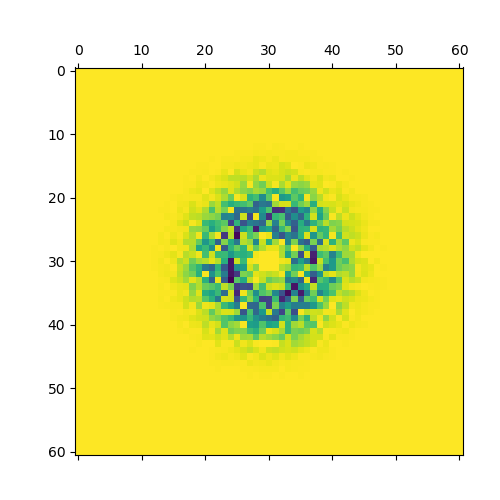

<IPython.core.display.Javascript object>


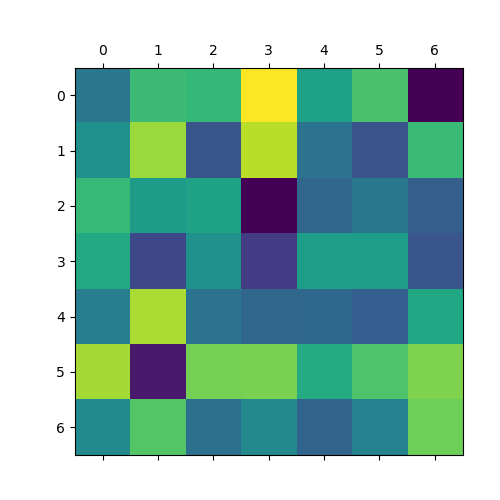

<IPython.core.display.Javascript object>


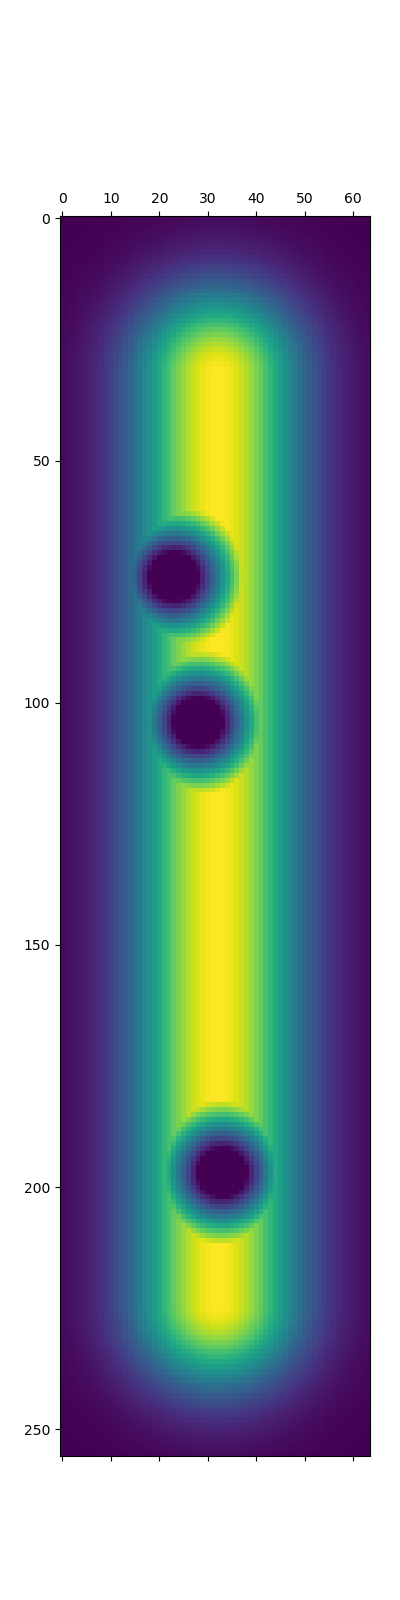

In [6]:
plt.rcParams['figure.figsize'] = [5, 5]

GCN = GCN2D(256,
            64,
            30,
            .75,
            450.,
            3,
            wideningFactor=2,
            excitationCenterBlock=-1,
            globalTonic=.1,
            stdpWindow=2,
            dt=0.01,
            placeMax=1.,
            placeMean=.25,
            boostEffect=1.,
            boostDecay=.5,
            numPlaces=1000,
            circularPlaces=True,
            learningRate=.25/4000,
            initialWeightFactor=1.2,
            initialExcitatoryFactor=0.05,
            boostGradientX=20,
            decayGradientX=5.,
            tonicGradientX=3.,
            inhibitionGradientX=1.,
            weightDecay=5000,
            decayConstant=0.03,
            negativeLearnFactorP=.9,
            negativeLearnFactorE=1.2,
            learningRateE=0,
            envelopeWidth=32,
            envelopeFactor=3.5,
            sigmaLoc=(.15)**2,
            hardwireE=False,
            hardwireEStrength=1.,
            hardwireERange=.05,
            hardwireEOffset=2.,
            excitationGradientX=10.,
            gradientType=.7,
            envSize=.5,
            weightNoise=2.)

GCN.randomLesions(3, 15, 5)

# plt.matshow(GCN.filter[0,0])
# plt.show()

plt.matshow(GCN.inhibitoryWeights[:, :, -1].view(61, 61).detach())
plt.show()


# plt.matshow(GCN.excitatoryWeights["s"][:, :, 8].view(25, 25).detach())
# plt.show()


# plt.matshow(GCN.excitatoryWeights["e"][:, :, 8].view(GCN.excitationWindow*2+1, GCN.excitationWindow*2+1).detach())
# plt.show()

# plt.matshow(GCN.excitationMask[:, :, 0].view(GCN.excitationWindow*2+1, GCN.excitationWindow*2+1).detach())
# plt.show()

plt.matshow(GCN.excitatoryWeights["w"][:, :, -1].view(7, 7).detach())
plt.show()

plt.matshow(GCN.envelope)
plt.show()


# plt.matshow(GCN.globalTonic)
# plt.show()

# plt.figure()
# plt.scatter(GCN.places[:, 0].cpu().numpy(),
#              GCN.places[:, 1].cpu().numpy())
# plt.show()

In [19]:
print(GCN.negativeLearnFactorI)
print(GCN.learningRate)
print(GCN.inhibitionWindowX)
print(GCN.decayGradient)

1.0
0.001
64


AttributeError: 'GCN2D' object has no attribute 'decayGradient'

In [12]:
try:
    del GCN
    del results
except:
    pass

with open("fixed10.pkl", "rb") as f:
    GCN = pkl.load(f)
    
with open("fixed10_results.pkl", "rb") as f:
    results = pkl.load(f)

<IPython.core.display.Javascript object>


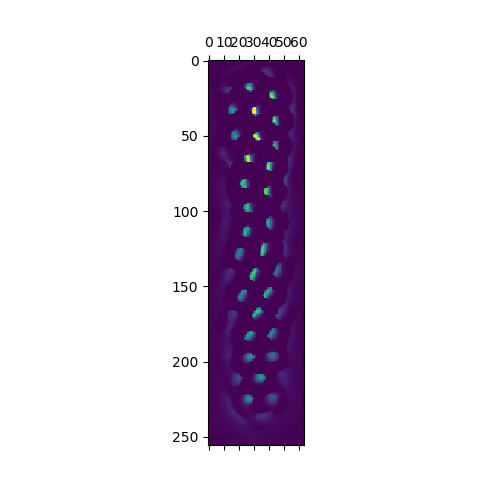

In [20]:
plt.rcParams['figure.figsize'] = [5, 5]
anim = createMovie(results[100:], "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4", 5)

<IPython.core.display.Javascript object>


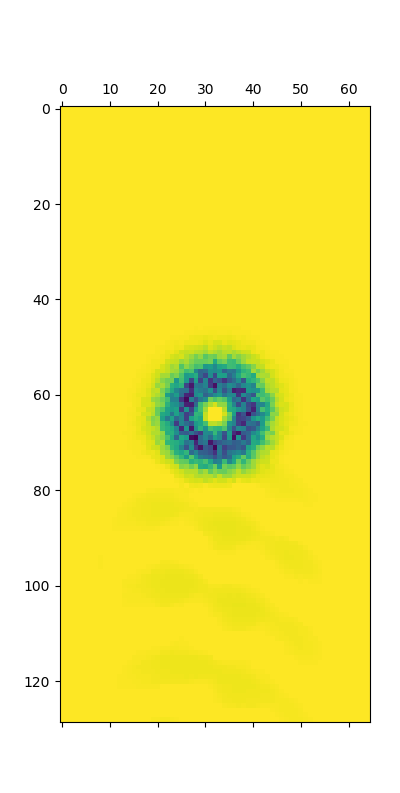

<IPython.core.display.Javascript object>


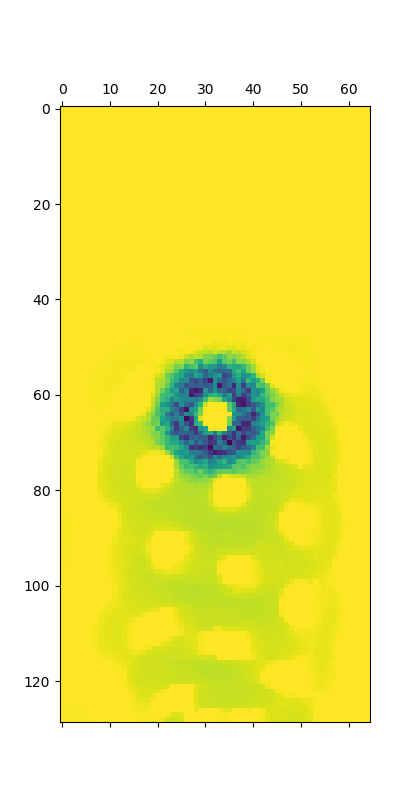

<IPython.core.display.Javascript object>


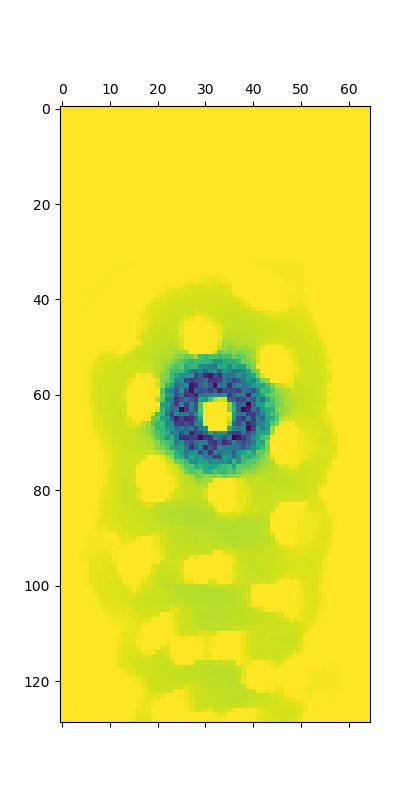

<IPython.core.display.Javascript object>


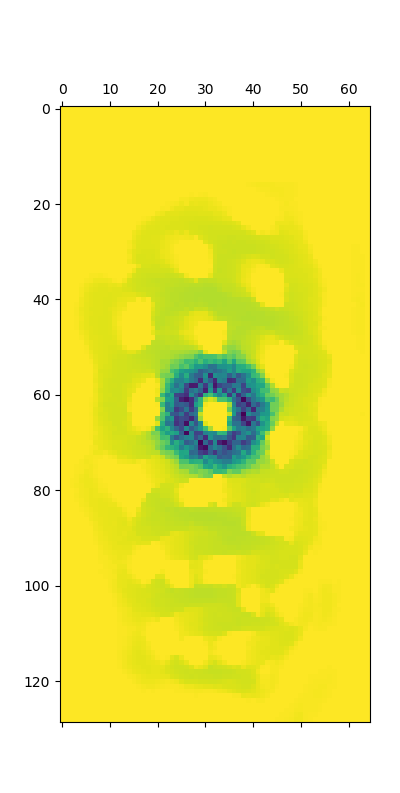

<IPython.core.display.Javascript object>


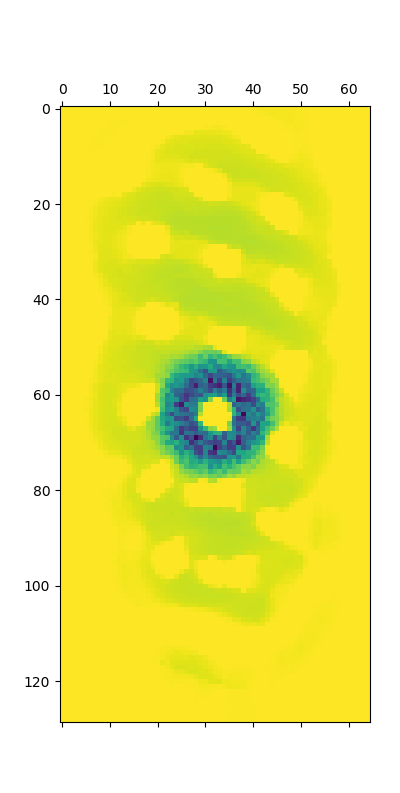

<IPython.core.display.Javascript object>


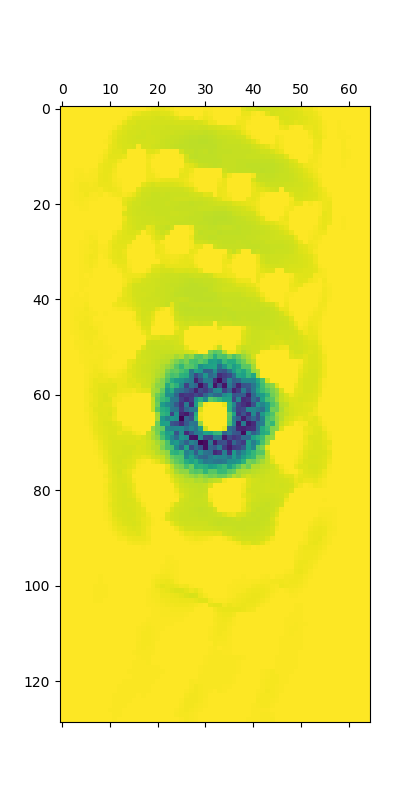

<IPython.core.display.Javascript object>


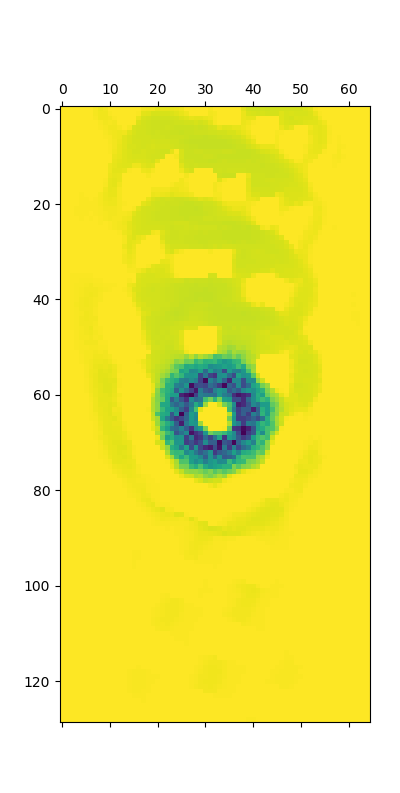

<IPython.core.display.Javascript object>


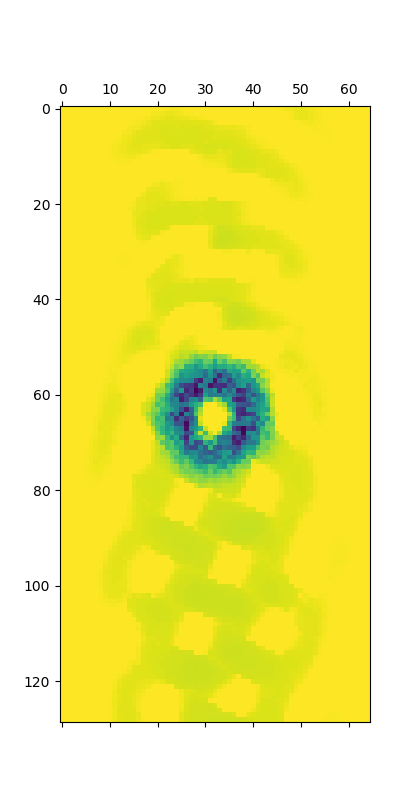

<IPython.core.display.Javascript object>


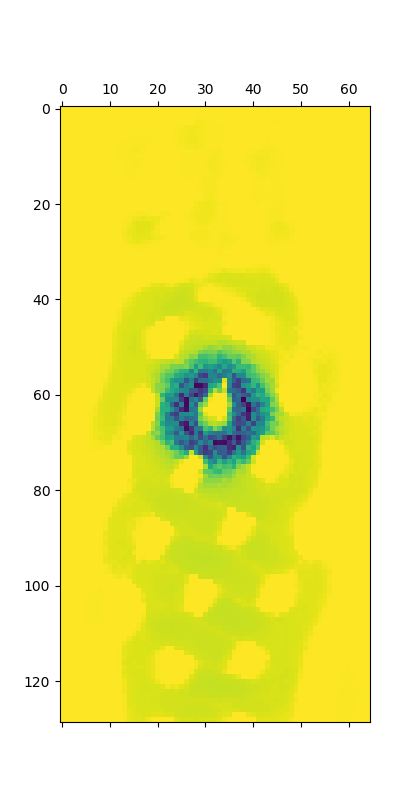

<IPython.core.display.Javascript object>


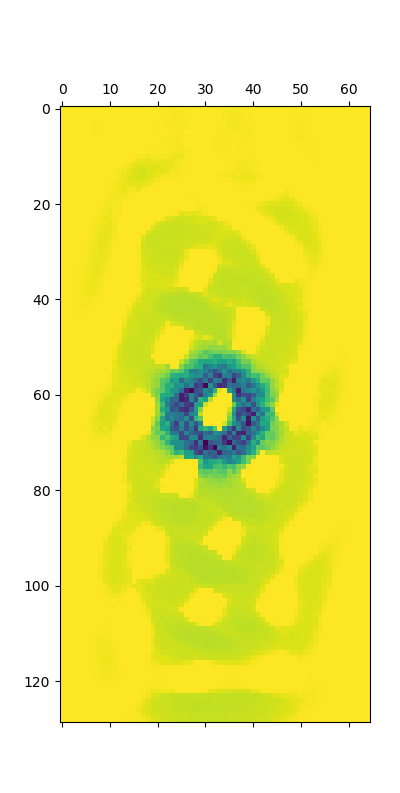

<IPython.core.display.Javascript object>


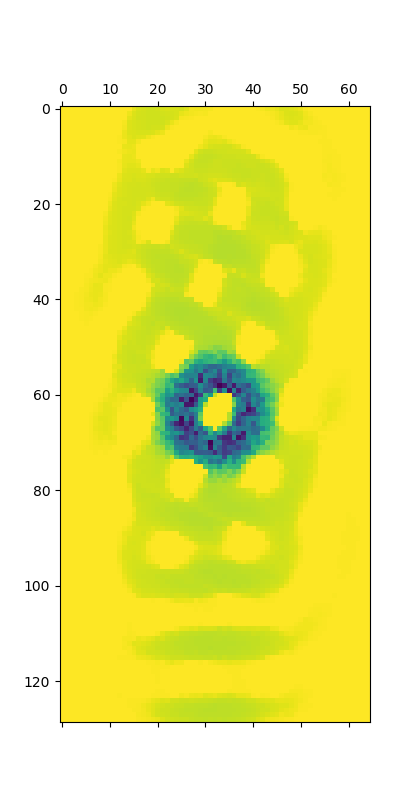

<IPython.core.display.Javascript object>


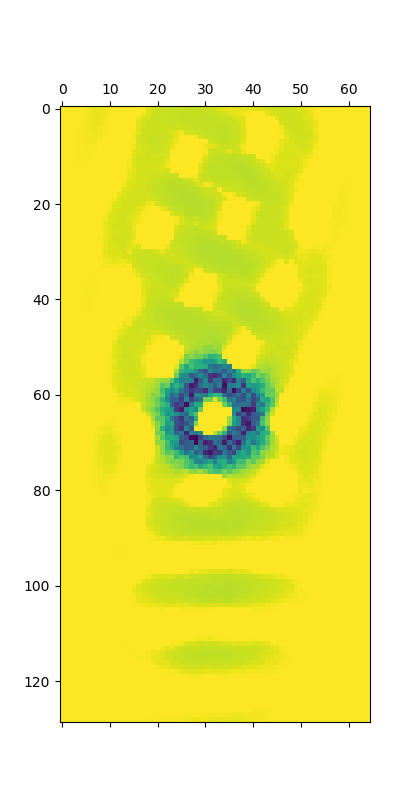

<IPython.core.display.Javascript object>


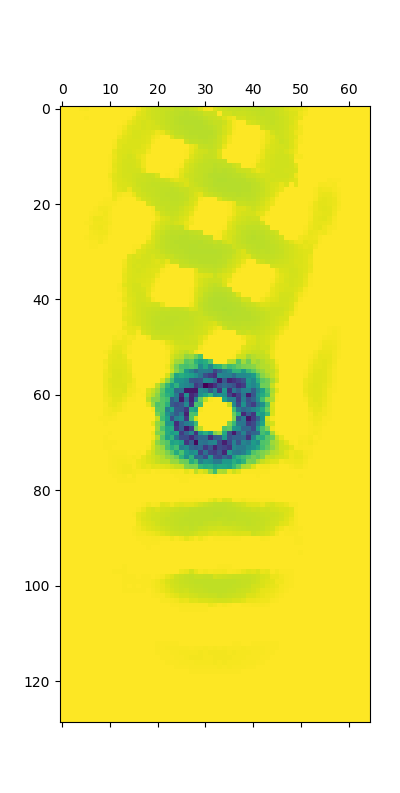

<IPython.core.display.Javascript object>


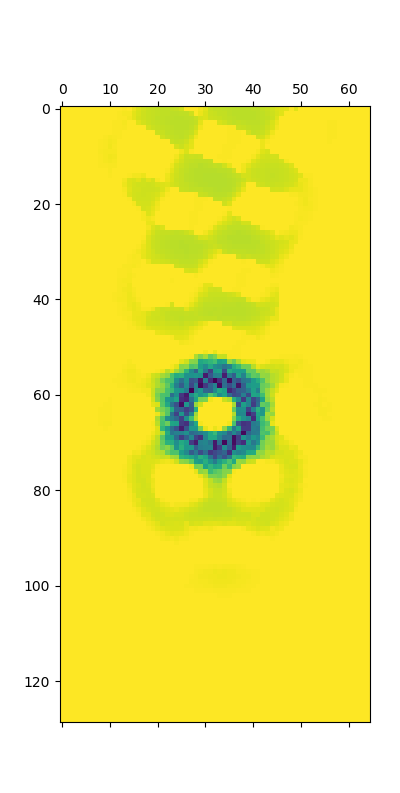

<IPython.core.display.Javascript object>


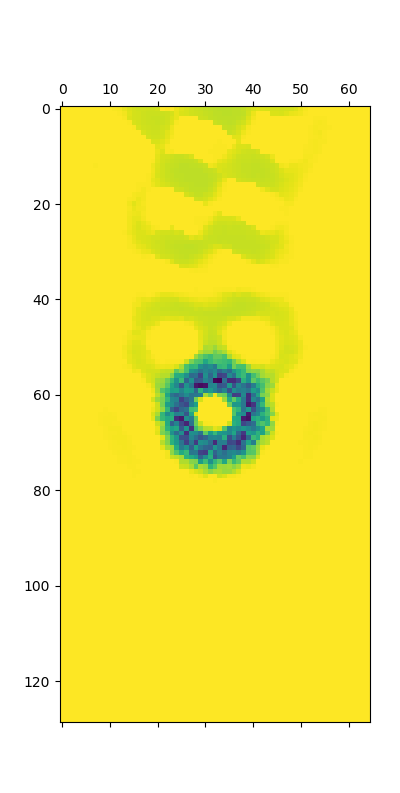

<IPython.core.display.Javascript object>


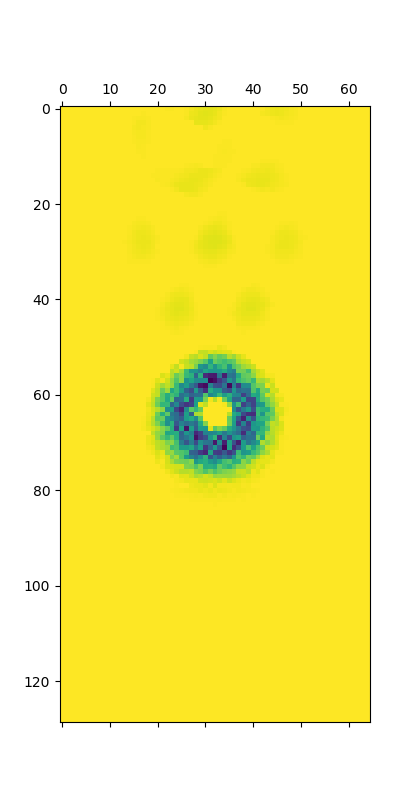

In [14]:
size = int(np.sqrt(GCN.inhibitoryWeights.shape[-1]))
for i in np.arange(0, 256, 16):
    plt.matshow((GCN.inhibitoryWeights[0, :, 64*i+ 32]).detach().view(GCN.inhibitoryKernel))


In [23]:
torch.mean(GCN.inhibitoryWeights.cpu())

tensor(-0.1231)

In [19]:
GCN.instantaneous.shape

torch.Size([1, 1, 256, 64])

<IPython.core.display.Javascript object>


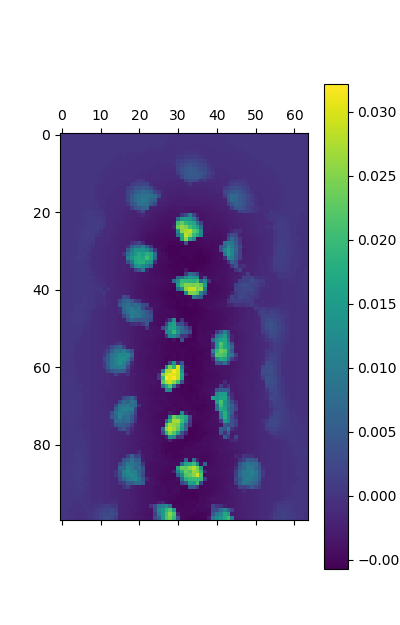

In [24]:
plt.matshow(GCN.instantaneous[0,0, :100] - GCN.longHistory[0, 0, :100])
plt.colorbar()

At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 8.43
At 8.44
At 8.45
At 8.46
At 8.47
At 8.48
At 8.49
At 8.5
At 8.51
At 8.52
At 8.53
At 8.540000000000001
At 8.55
At 8.56
At 8.57
At 8.58
At 8.59
At 8.6
At 8.61
At 8.620000000000001
At 8.63
At 8.64
At 8.65
At 8.66
At 8.67
At 8.68
At 8.69
At 8.700000000000001
At 8.71
At 8.72
At 8.73
At 8.74
At 8.75
At 8.76
At 8.77
At 8.78
At 8.790000000000001
At 8.8
At 8.81
At 8.82
At 8.83
At 8.84
At 8.85
At 8.86
At 8.870000000000001
At 8.88
At 8.89
At 8.9
At 8.91
At 8.92
At 8.93
At 8.94
At 8.950000000000001
At 8.96
At 8.97
At 8.98
At 8.99
At 9.0
At 9.01
At 9.02
At 9.03
At 9.040000000000001
At 9.05
At 9.06
At 9.07
At 9.08
At 9.09
At 9.1
At 9.11
At 9.120000000000001
At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.46
At 9.47
At 9.48
At 9

At 16.27
At 16.28
At 16.29
At 16.3
At 16.31
At 16.32
At 16.330000000000002
At 16.34
At 16.35
At 16.36
At 16.37
At 16.38
At 16.39
At 16.4
At 16.41
At 16.42
At 16.43
At 16.44
At 16.45
At 16.46
At 16.47
At 16.48
At 16.490000000000002
At 16.5
At 16.51
At 16.52
At 16.53
At 16.54
At 16.55
At 16.56
At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.03
At 17.04
At 17.05
At 17.06
At 17.07
At 17.080000000000002
At 17.09
At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
At 17.2
At 17.21
At 17.22
At 17.23
At 17.240000000000002
At 17.25
At

At 24.150000000000002
At 24.16
At 24.17
At 24.18
At 24.19
At 24.2
At 24.21
At 24.22
At 24.23
At 24.240000000000002
At 24.25
At 24.26
At 24.27
At 24.28
At 24.29
At 24.3
At 24.310000000000002
At 24.32
At 24.330000000000002
At 24.34
At 24.35
At 24.36
At 24.37
At 24.38
At 24.39
At 24.400000000000002
At 24.41
At 24.42
At 24.43
At 24.44
At 24.45
At 24.46
At 24.47
At 24.48
At 24.490000000000002
At 24.5
At 24.51
At 24.52
At 24.53
At 24.54
At 24.55
At 24.560000000000002
At 24.57
At 24.580000000000002
At 24.59
At 24.6
At 24.61
At 24.62
At 24.63
At 24.64
At 24.650000000000002
At 24.66
At 24.67
At 24.68
At 24.69
At 24.7
At 24.71
At 24.72
At 24.73
At 24.740000000000002
At 24.75
At 24.76
At 24.77
At 24.78
At 24.79
At 24.8
At 24.810000000000002
At 24.82
At 24.830000000000002
At 24.84
At 24.85
At 24.86
At 24.87
At 24.88
At 24.89
At 24.900000000000002
At 24.91
At 24.92
At 24.93
At 24.94
At 24.95
At 24.96
At 24.97
At 24.98
At 24.990000000000002
At 25.0
At 25.01
At 25.02
At 25.03
At 25.04
At 25.05
At 25.

At 31.62
At 31.63
At 31.64
At 31.650000000000002
At 31.66
At 31.67
At 31.68
At 31.69
At 31.7
At 31.71
At 31.720000000000002
At 31.73
At 31.740000000000002
At 31.75
At 31.76
At 31.77
At 31.78
At 31.79
At 31.8
At 31.810000000000002
At 31.82
At 31.830000000000002
At 31.84
At 31.85
At 31.86
At 31.87
At 31.88
At 31.89
At 31.900000000000002
At 31.91
At 31.92
At 31.93
At 31.94
At 31.95
At 31.96
At 31.970000000000002
At 31.98
At 31.990000000000002
At 32.0
At 32.01
At 32.02
At 32.03
At 32.04
At 32.05
At 32.06
At 32.07
At 32.08
At 32.09
At 32.1
At 32.11
At 32.12
At 32.13
At 32.14
At 32.15
At 32.160000000000004
At 32.17
At 32.18
At 32.19
At 32.2
At 32.21
At 32.22
At 32.230000000000004
At 32.24
At 32.25
At 32.26
At 32.27
At 32.28
At 32.29
At 32.3
At 32.31
At 32.32
At 32.33
At 32.34
At 32.35
At 32.36
At 32.37
At 32.38
At 32.39
At 32.4
At 32.410000000000004
At 32.42
At 32.43
At 32.44
At 32.45
At 32.46
At 32.47
At 32.480000000000004
At 32.49
At 32.5
At 32.51
At 32.52
At 32.53
At 32.54
At 32.55
At 32.

At 39.57
At 39.58
At 39.59
At 39.6
At 39.61
At 39.62
At 39.63
At 39.64
At 39.65
At 39.660000000000004
At 39.67
At 39.68
At 39.69
At 39.7
At 39.71
At 39.72
At 39.730000000000004
At 39.74
At 39.75
At 39.76
At 39.77
At 39.78
At 39.79
At 39.800000000000004
At 39.81
At 39.82
At 39.83
At 39.84
At 39.85
At 39.86
At 39.87
At 39.88
At 39.89
At 39.9
At 39.910000000000004
At 39.92
At 39.93
At 39.94
At 39.95
At 39.96
At 39.97
At 39.980000000000004
At 39.99
At 40.0
At 40.01
At 40.02
At 40.03
At 40.04
At 40.050000000000004
At 40.06
At 40.07
At 40.08
At 40.09
At 40.1
At 40.11
At 40.12
At 40.13
At 40.14
At 40.15
At 40.160000000000004
At 40.17
At 40.18
At 40.19
At 40.2
At 40.21
At 40.22
At 40.230000000000004
At 40.24
At 40.25
At 40.26
At 40.27
At 40.28
At 40.29
At 40.300000000000004
At 40.31
At 40.32
At 40.33
At 40.34
At 40.35
At 40.36
At 40.37
At 40.38
At 40.39
At 40.4
At 40.410000000000004
At 40.42
At 40.43
At 40.44
At 40.45
At 40.46
At 40.47
At 40.480000000000004
At 40.49
At 40.5
At 40.51
At 40.52
A

At 47.4
At 47.410000000000004
At 47.42
At 47.43
At 47.44
At 47.45
At 47.46
At 47.47
At 47.480000000000004
At 47.49
At 47.5
At 47.51
At 47.52
At 47.53
At 47.54
At 47.550000000000004
At 47.56
At 47.57
At 47.58
At 47.59
At 47.6
At 47.61
At 47.62
At 47.63
At 47.64
At 47.65
At 47.660000000000004
At 47.67
At 47.68
At 47.69
At 47.7
At 47.71
At 47.72
At 47.730000000000004
At 47.74
At 47.75
At 47.76
At 47.77
At 47.78
At 47.79
At 47.800000000000004
At 47.81
At 47.82
At 47.83
At 47.84
At 47.85
At 47.86
At 47.870000000000005
At 47.88
At 47.89
At 47.9
At 47.910000000000004
At 47.92
At 47.93
At 47.94
At 47.95
At 47.96
At 47.97
At 47.980000000000004
At 47.99
At 48.0
At 48.01
At 48.02
At 48.03
At 48.04
At 48.050000000000004
At 48.06
At 48.07
At 48.08
At 48.09
At 48.1
At 48.11
At 48.120000000000005
At 48.13
At 48.14
At 48.15
At 48.160000000000004
At 48.17
At 48.18
At 48.19
At 48.2
At 48.21
At 48.22
At 48.230000000000004
At 48.24
At 48.25
At 48.26
At 48.27
At 48.28
At 48.29
At 48.300000000000004
At 48.3

<IPython.core.display.Javascript object>


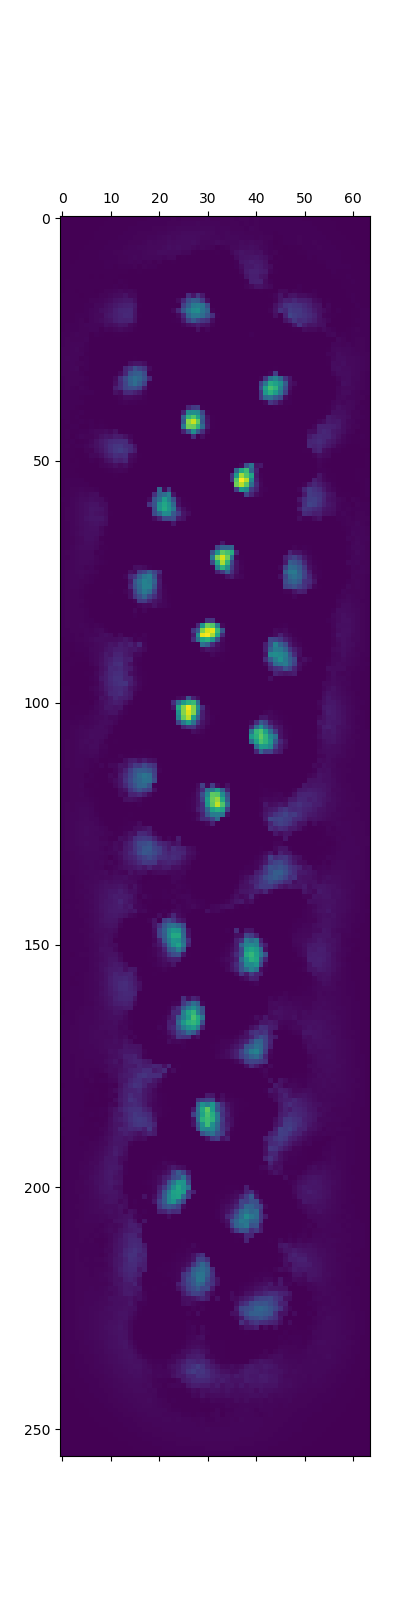

In [34]:
plt.rcParams['figure.figsize'] = [5, 5]
results = GCN.simulate(50, logFreq=1, startFrom = 0, vel = (0, 0))
plt.matshow(results[-2])
plt.show()

<IPython.core.display.Javascript object>


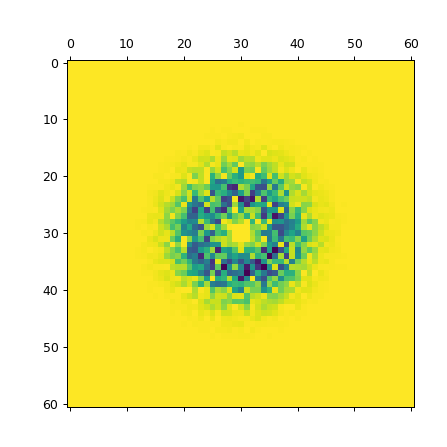

In [41]:
plt.matshow(GCN.inhibitoryWeights[:, :, 125*64 + 25].view(61, 61).detach())
plt.show()



In [39]:
plt.rcParams['figure.figsize'] = [5, 5]
for i in range(50):
    print(i)
    GCN.staticLearning(200, logFreq=100000, startFrom = 100.)

0


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


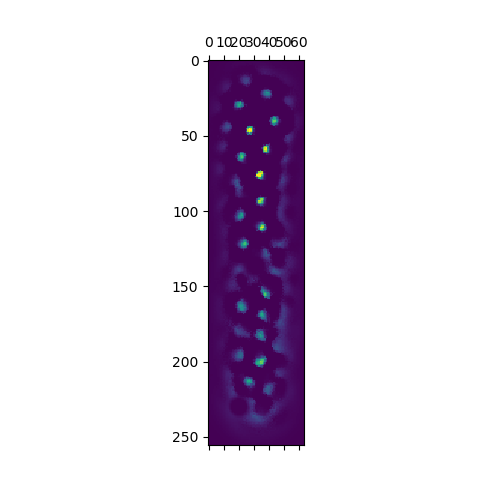

In [35]:
plt.rcParams['figure.figsize'] = [5, 5]
anim = createMovie(results[-1000:], "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4", 5)

In [ ]:
plt.rcParams['figure.figsize'] = [5, 15]
lr = 1.#GCN.learningRate
for i in range(1000):
    GCN.learningRate = lr/(i+17)
    print(i, GCN.learningRate)
    GCN.learn(150,
              plotting=False,
              learnStart=1.5,
              stab=0.98,
              speed=.1,
              circular=True,
              localNormalization=False)

In [ ]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
xstart = 28
xend = 32
ystart = 28
yend = 32
for i in range(xstart, xend):
    for j in range(ystart, yend):
        index = (i - xstart)*(yend - ystart) + (j - ystart) + 1
        plt.subplot((xend - xstart), (yend - ystart), index)
        plt.scatter(GCN.places[:, 0].cpu().numpy(),
                    GCN.places[:, 1].cpu().numpy(),
                    c = GCN.placeWeights[i, j, :].cpu().numpy(),
                    cmap = plt.get_cmap("coolwarm"))
        plt.draw()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.figure()
plt.scatter(GCN.places[:, 0].cpu().numpy(),
            GCN.places[:, 1].cpu().numpy(),
            c = torch.mean(GCN.placeWeights.view(GCN.numX*GCN.numY, GCN.numPlaces), dim=0).cpu().numpy(),
            cmap = plt.get_cmap("coolwarm"))
plt.colorbar()
plt.show()

plt.matshow(torch.mean(GCN.placeWeights, dim=-1).cpu().numpy(),
            cmap = plt.get_cmap("coolwarm"))
plt.colorbar()
plt.show()

In [ ]:
GCN.placeMax /= 2.
GCN.placeMean /= 2.

In [ ]:
GCN.learningRate = 5.
plt.rcParams['figure.figsize'] = [5, 20]
GCN.learn(5.,
          plotting=True,
          plotInterval=5,
          oneD=False,
          learnStart=0.,
          stab=.99,
          circular=True,
          speed=.25,
          localNormalization=True)

In [ ]:
window=GCN.excitationWindow

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(torch.mean(GCN.excitatoryWeights["e"], dim=-1).view(window*2+1, window*2+1).detach(), vmin=0, vmax=0.3)
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(torch.mean(GCN.excitatoryWeights["w"], dim=-1).view(window*2+1, window*2+1).detach(), vmin=0, vmax=0.3)
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(torch.mean(GCN.excitatoryWeights["n"], dim=-1).view(window*2+1, window*2+1).detach(), vmin=0, vmax=0.3)
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(torch.mean(GCN.excitatoryWeights["s"], dim=-1).view(window*2+1, window*2+1).detach(), vmin=0, vmax=0.3)
plt.show()

In [ ]:
torch.mean(GCN.excitatoryWeights["w"][:, :, 24*48 + 24])

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.matshow(GCN.activity.view(GCN.numX, GCN.numY).cpu().numpy())
cols = unfold(GCN.activity, (25, 25), 1, (12, 12), (1, 1))

plt.matshow(cols[:, :, 55*(96)+33].view(25, 25).cpu().numpy())

weights = GCN.excitatoryWeights["n"]
results = cols*weights
plt.matshow(weights[:, :, 55*96 + 33].view(25, 25).cpu().numpy())
plt.matshow(results[:, :, 55*(96)+33].view(25, 25).cpu().numpy())

In [ ]:
weights = GCN.placeWeights.cpu().numpy()
with open("PlaceWeights2.npz", "wb") as f:
    np.savez(f, weights)

places = GCN.places.cpu().numpy()
with open("Places2.npz", "wb") as f:
    np.savez(f, places)


In [ ]:
with open("PlaceWeights.npz", "rb") as f:
    weights = np.load(f)["arr_0"]
GCN.placeWeights = torch.tensor(weights, device=device, dtype=torch.float)
with open("Places.npz", "rb") as f:
    places = np.load(f)["arr_0"]

GCN.places = torch.tensor(places, device=device, dtype=torch.float)

In [ ]:
mask = np.zeros((GCN.numX, GCN.numY))

for i in range(0, GCN.numX, 1):
    for j in range(0, GCN.numY, 1):
        mask[i, j] = 1.

processedResults, flowVelocities, flowColors = get_data_flow_and_color_maps(results[1100:1150], GCN.numX, GCN.numY, mask, 1)
processedResults = processedResults.reshape(-1, GCN.numX, GCN.numY)
flowColors = flowColors.reshape(-1, GCN.numX, GCN.numY, 3)

In [ ]:
def createMovieWithFlow(data, colors, name):
    def update(num, data, a):
        results, flowColors = data
        a[0].set_data(results[num])
        a[1].set_data(flowColors[num])
        return a,

    fig, ax   = plt.subplots(1,2)

    a0  = ax[0].imshow(data[0], animated=True)
    a1  = ax[1].imshow(colors[0], animated=True)

    ani = animation.FuncAnimation(fig, update, data.shape[0] - 1, fargs=((data, colors,), (a0,a1)),
                                   interval=10, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
createMovieWithFlow(processedResults, flowColors,
                      "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\flowtest.mp4")